In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
from scipy.interpolate import interpn
import pynbody

In [3]:
datadir = '/home/pdcg/Documents/post_process_routines/'
simulation = 'size_evo/'
s = pynbody.load(datadir+simulation+'snapdir_127/snapshot_127')

/home/pdcg/anaconda3/lib/python3.9/site-packages/pynbody/snapshot/gadgethdf.py:370: UserWarning: Masses are either stored in the header or have another dataset name; assuming the cosmological factor h**-1
  warnings.warn("Masses are either stored in the header or have another dataset name; assuming the cosmological factor %s" % units.h**-1)


In [4]:
s['eps'] = s['smooth']

In [5]:
h = s.halos()

In [6]:
transform = pynbody.analysis.angmom.faceon(h[1])

In [7]:
s.physical_units()

In [10]:
mask_clusters_initial = h[1].s['InitialNumberOfClusters'] > 0
mask_clusters_final = h[1].s['NumberOfClusters'] > 0

truncation_mass = h[1].s['ICMFTruncationMass'][mask_clusters_initial]
cluster_masses = h[1].s['ClusterMass'][mask_clusters_initial].flatten()
cluster_radius = h[1].s['ClusterRadius'][mask_clusters_initial].flatten()
init_cluster_masses = h[1].s['InitialClusterMass'][mask_clusters_initial].flatten()
init_cluster_radius = h[1].s['InitialClusterRadius'][mask_clusters_initial].flatten()
masslostrelax = h[1].s['MassLostRelaxation'][mask_clusters_initial].flatten()
masslostshock = h[1].s['MassLostShocks'][mask_clusters_initial].flatten()

not_empty_clusters = (init_cluster_masses>0)

cluster_masses = cluster_masses[not_empty_clusters]
cluster_radius = cluster_radius[not_empty_clusters]
init_cluster_masses = init_cluster_masses[not_empty_clusters]
init_cluster_radius = init_cluster_radius[not_empty_clusters]
masslostrelax = masslostrelax[not_empty_clusters]
masslostshock = masslostshock[not_empty_clusters]

print('Maximum initial mass {:2.2e} Msun'.format(init_cluster_masses.max()))
print('Maximum present-day mass {:2.2e} Msun'.format(cluster_masses.max()))

Maximum initial mass 2.00e+07 Msun
Maximum present-day mass 1.11e+07 Msun


In [11]:
clusters_birthtime = []
clusters_age = []
for i, nclt in enumerate(h[1].s['InitialNumberOfClusters'][mask_clusters_initial]):
  clusters_birthtime.append(np.ones(nclt) * h[1].s['tform'].in_units('Gyr')[mask_clusters_initial][i])
  clusters_age.append(np.ones(nclt) * h[1].s['age'].in_units('Gyr')[mask_clusters_initial][i])

clusters_birthtime = np.concatenate(clusters_birthtime)
clusters_age = np.concatenate(clusters_age)

In [12]:
clusters_disruptiontime = h[1].s['DisruptionTime'][mask_clusters_initial].flatten()
clusters_disruptiontime = clusters_disruptiontime[not_empty_clusters]
disruption_gyr = np.nan_to_num(pynbody.analysis.cosmology.age(s,z = 1./clusters_disruptiontime - 1.), nan=0.)

/tmp/ipykernel_23336/538201836.py:3: RuntimeWarning: divide by zero encountered in divide
  disruption_gyr = np.nan_to_num(pynbody.analysis.cosmology.age(s,z = 1./clusters_disruptiontime - 1.), nan=0.)
/home/pdcg/anaconda3/lib/python3.9/site-packages/pynbody/analysis/cosmology.py:182: RuntimeWarning: divide by zero encountered in log
  log_a_input = np.log(1./(1.+z))


In [13]:
lifetime_gyr = disruption_gyr - clusters_birthtime
lifetime_gyr[np.logical_not(disruption_gyr>0)] = 16

In [ ]:
young_mask = (clusters_age<0.5)
old_mask = (clusters_age>4)
veryold_mask = (clusters_age>6)

In [14]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density=False)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    h = ax.scatter( x, y, c=z, norm='log', cmap=cm.viridis, **kwargs )

    return ax, h

In [18]:
min_icmf = 5e3 # in solar masses
max_icmf = 1e8 # in solar masses
marray_icmf = np.logspace(np.log10(min_icmf), np.log10(max_icmf), 25)

min_gcmf = 1e2 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.logspace(np.log10(min_gcmf), np.log10(max_gcmf), 25)

min_rh = 5e-2 # in parsecs
max_rh = 2e2 # in parsecs
rharray = np.logspace(np.log10(min_rh), np.log10(max_rh), 25) # in pc

Text(0, 0.5, 'Number')

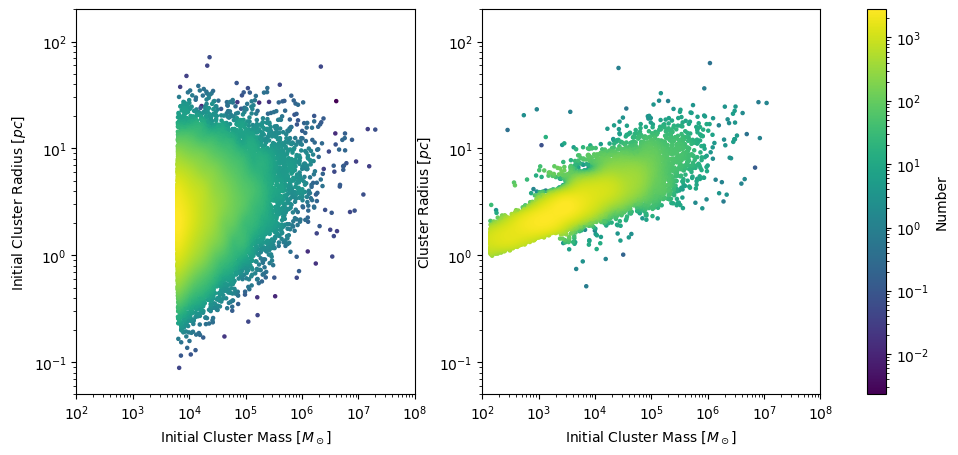

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0], cb = density_scatter(init_cluster_masses, init_cluster_radius*1e3, ax=ax[0],bins=[marray_icmf, rharray], edgecolors='face', s=5)
ax[0].set(xscale='log', yscale='log', xlim=(1e2, 1e8), ylim=(5e-2, 2e2), xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Radius}$ [$pc$]')

ax[1], cb = density_scatter(cluster_masses, cluster_radius*1e3, ax=ax[1],bins=[marray_gcmf, rharray], edgecolors='face', s=5)
ax[1].set(xscale='log', yscale='log', xlim=(1e2, 1e8), ylim=(5e-2, 2e2), xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\rm{Cluster}$ $\rm{Radius}$ [$pc$]')

cbar = fig.colorbar(cb, ax=ax)
cbar.ax.set_ylabel('Number')

In [45]:
lossratio = masslostshock/masslostrelax

Text(0, 0.5, 'Ratio shock/evaporation mass loss')

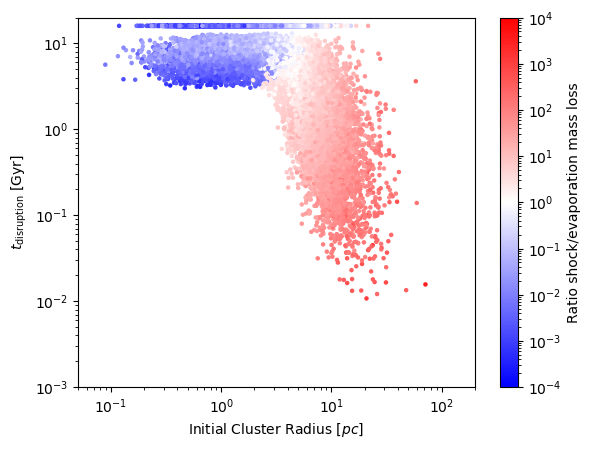

In [46]:
fig, ax = plt.subplots(1, 1)
cb = ax.scatter(init_cluster_radius*1e3, lifetime_gyr, edgecolors='face', s=5, c=lossratio, cmap=cm.bwr, norm=colors.LogNorm(vmin=1e-4, vmax=1e4))
ax.set(xscale='log', yscale='log', xlim=(5e-2, 2e2), ylim=(1e-3, 2e1))
ax.set(xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Radius}$ [$pc$]', ylabel=r'$t_{\rm{disruption}}$ [$\rm{Gyr}$]')
cbar = fig.colorbar(cb, ax=ax)
cbar.ax.set_ylabel('Ratio shock/evaporation mass loss')